In [419]:
"""The FDA&#39;s database of adverse event reports is made available through a web API at
https://open.fda.gov/apis/try-the-api/ Each report contains general information about the
report, patient information, a list of the drugs that the patient is taking, and a list of the patient
reactions.  It is possible to use these data in many ways: your brief is to explore these data and to
see what might be learned from them.  As a guide, you might consider a practical solution to one of
the following questions: 
 
 Are different adverse events reported in different countries? 
 What are the different adverse events associated with different disease areas? 
 What drugs tend to be taken together? 
"""

'The FDA&#39;s database of adverse event reports is made available through a web API at\nhttps://open.fda.gov/apis/try-the-api/ Each report contains general information about the\nreport, patient information, a list of the drugs that the patient is taking, and a list of the patient\nreactions.\xa0 It is possible to use these data in many ways: your brief is to explore these data and to\nsee what might be learned from them.\xa0 As a guide, you might consider a practical solution to one of\nthe following questions:\xa0\n\xa0\n\uf0b7 Are different adverse events reported in different countries?\xa0\n\uf0b7 What are the different adverse events associated with different disease areas?\xa0\n\uf0b7 What drugs tend to be taken together?\xa0\n'

In [374]:
# import all the dependencies
import pandas as pd
import json
import requests
import time
from collections import defaultdict
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import networkx as nx
stopwords = set(STOPWORDS)


In [285]:
# Given a list of words return wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [10]:
# countries with high number of report counts
response = requests.get("https://api.fda.gov/drug/event.json?count=occurcountry.exact")
data = json.loads(response.text)
df = pd.DataFrame(data['results'])
df.head()

,term,count
0,US,6136862
1,GB,298758
2,CA,260177
3,JP,259359
4,FR,250505


In [85]:
# access all the reports submitted to FDA in last year
response = requests.get("https://api.fda.gov/drug/event.json?search=_exists_: primarysource +receivedate:[2019-07-01+TO+2020-06-30]&limit=1")
data = json.loads(response.text)
total_records = data['meta']['results']['total']

11806673

In [165]:
# it will take significant time to access 11806673 reports using this API. Instrad reading 10,000 reports submitted last year

starttime = time.time()

records_read = 0
processed_data=[]

while records_read < 10000:
    response = requests.get("https://api.fda.gov/drug/event.json?search=_exists_: primarysource +receivedate:[2019-07-01+TO+2020-06-30]&limit=200&skip={}".format(records_read))
    records_read += 200
    data = json.loads(response.text)
    
# read each of the 200 report result retrieved
    for index,val in enumerate(data['results']):
        data_dict = {}
        try:
            data_dict['country'] =  data['results'][index]['primarysource']['reportercountry'].lower()
        except:
            data_dict['country'] = None
        
        try:
            data_dict['reporter'] = data['results'][index]['primarysource']['qualification']    
        except:
            data_dict['reporter'] = None
            
        try:
            data_dict['age'] = data['results'][index]['patient']['patientonsetage']
        except:
            data_dict['age'] = None
            
        try:
            data_dict['gender'] = data['results'][index]['patient']['patientsex']
        except:
            data_dict['gender'] = None    
        try:
            reaction_list = data['results'][index]['patient']['reaction']
        except:
            reaction_list = None
        data_dict['reactions'] = [d['reactionmeddrapt'].lower() for d in reaction_list]
        

            
        try:
            drug_list = data['results'][index]['patient']['drug']
        except:
            drug_list = None 

        data_dict['suspect_drug']=[]
        data_dict['drugindication']=[]
        data_dict['concomitant_drug']=[]
        data_dict['interacting_drug']=[]
        
#read each of the drug listed in each report
        for drug in drug_list:
            if drug['drugcharacterization'] == '1':
                
                try:
                    name = drug['medicinalproduct'].lower()
                except:
                    name = None
                
                
                try:
                    indication = drug['drugindication'].lower()
                except:
                    indication = None
                    
                data_dict['suspect_drug'].append(name)
                data_dict['drugindication'].append(indication)
                    
                    
            elif drug['drugcharacterization'] == '2':
                data_dict['concomitant_drug'].append(drug['medicinalproduct'].lower())
            elif drug['drugcharacterization'] == '3':
                data_dict['interacting_drug'].append(drug['medicinalproduct'].lower())
        
        processed_data.append(data_dict)
   
    time.sleep(60.0 - ((time.time() - starttime) % 60.0))
   

In [166]:
# load the important information from 10,000 records  into a dataframe
df = pd.DataFrame(processed_data)
df.head(20)

,country,reporter,age,gender,reactions,suspect_drug,drugindication,concomitant_drug,interacting_drug
0,canada,3,26,1,"[drug administration error, overdose]",[duragesic-100],[drug abuse],[],[]
1,us,5,77,2,"[vomiting, diarrhoea, arthralgia, headache]",[boniva],[osteoporosis],[],[]
2,us,5,None,2,"[dyspepsia, renal impairment]",[ibuprofen],[product used for unknown indication],[],[]
3,us,5,None,1,[drug ineffective],[lyrica],[None],[],[]
4,us,1,None,2,[drug hypersensitivity],"[doxycycline hyclate, tramadol hydrochloride, ...","[None, None, None, None, None, None, None, Non...",[],[]
5,us,1,48,2,[drug hypersensitivity],"[lipitor, lisinopril, losartan potassium, meto...","[None, None, None, None, None, None]",[],[]
6,us,5,68,2,"[cough, throat irritation]","[letairis, tyvaso]","[product used for unknown indication, None]",[],[]
7,us,1,65,2,[rhinorrhoea],"[letairis, letairis]","[pulmonary hypertension, connective tissue dis...",[oxygen.],[]
8,us,1,59,2,"[unevaluable event, malaise]","[letairis, letairis]","[pulmonary hypertension, systemic sclerosis]",[],[]
9,us,5,42,1,[hepatic enzyme increased],"[letairis, letairis]","[sleep apnoea syndrome, pulmonary hypertension]",[],[]


In [233]:
# find which countries report whcih type of adverse drug reactions
df2 = df[['country','reactions']]

In [228]:
# count of total reports by each country
count_df = df2.groupby(['country'], as_index = False)[['reactions']].count()
count_df.rename(columns = {'reactions':'report_count'}, inplace=True)
count_df.head()

,country,report_count
0,ar,12
1,at,12
2,au,48
3,bd,12
4,be,18


In [234]:
# convert a list of reaction to multiple rows in this dataframe with indvidual row for each element
df2 = pd.DataFrame(df2.reactions.tolist(), index=df2.country).stack()
df2 = df2.reset_index()[[0, 'country']]
df2.columns = ['reactions', 'country']
df2.head()

,reactions,country
0,drug administration error,canada
1,overdose,canada
2,vomiting,us
3,diarrhoea,us
4,arthralgia,us


In [243]:
# merge total count and ADE specific counts
df2['reaction_count'] = 'tmp'
df2 = df2.groupby(['country','reactions'], as_index = False)[['reaction_count']].count()
df2 = pd.merge(df2,count_df, how = 'inner', on=['country'])
df2.head()

,country,reactions,reaction_count,report_count
0,ar,abscess,1,12
1,ar,affect lability,1,12
2,ar,anticonvulsant drug level decreased,1,12
3,ar,autoimmune disorder,1,12
4,ar,blood immunoglobulin e increased,1,12


In [252]:
# find the ADE with highest percentage of reports per country
df2['percentage_of_report'] = df2.reaction_count*100/df2.report_count
df3 = df2.loc[df2.groupby(['country','report_count'])['percentage_of_report'].idxmax()]
df3 = df3.sort_values(by='report_count', ascending = False)
df3.head()

,country,reactions,reaction_count,report_count,percentage_of_report
6999,us,type 2 diabetes mellitus,482,7613,6.331275
2905,gb,dyspnoea,28,333,8.408408
1354,country not specified,death,37,302,12.251656
599,ca,breast cancer,79,224,35.267857
3963,jp,drug ineffective,17,215,7.906977


In [254]:
# sort the data by country and pecentage of reports
df3 = df2.sort_values(by=['country','percentage_of_report'], ascending = False)
df3 = df3.groupby('country').head(5).reset_index(drop=True)
df3 = df3.sort_values(by='report_count', ascending = False)
df3.head()                          

,country,reactions,reaction_count,report_count,percentage_of_report
9,us,type 2 diabetes mellitus,482,7613,6.331275
10,us,dyspnoea,428,7613,5.621962
13,us,headache,343,7613,4.505451
12,us,fatigue,380,7613,4.991462
11,us,drug ineffective,403,7613,5.293577


In [265]:
# select top countries with at least 200 reprots
df3 = df3[df3.report_count>200]
countries = list(df3.country.unique())
countries

['us', 'gb', 'country not specified', 'ca', 'jp']

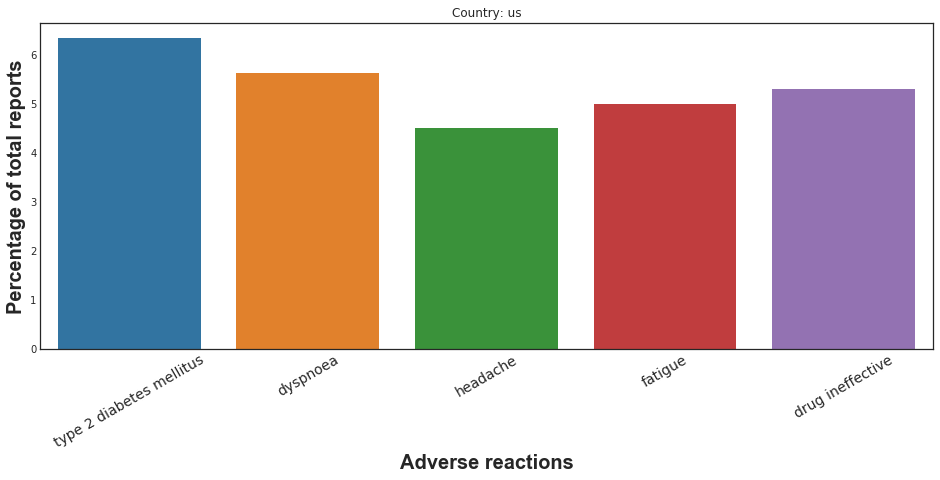

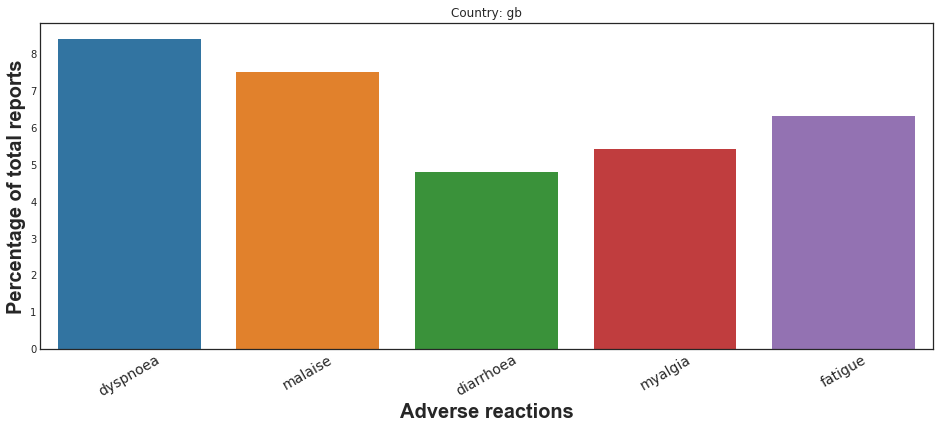

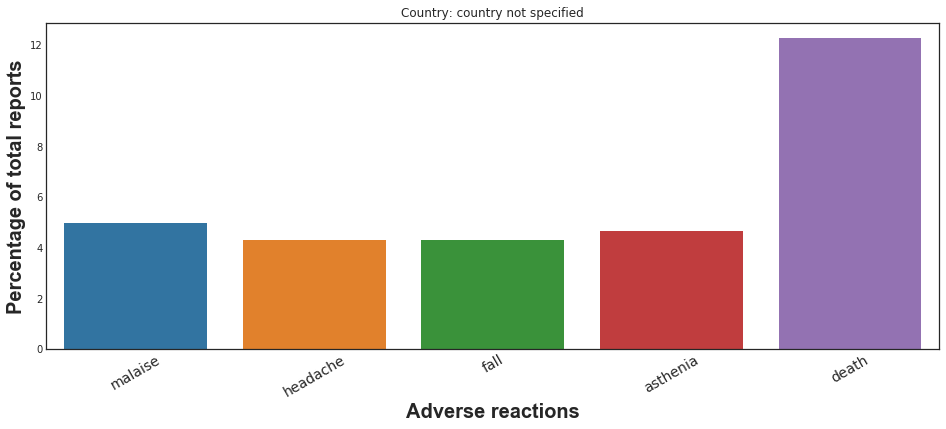

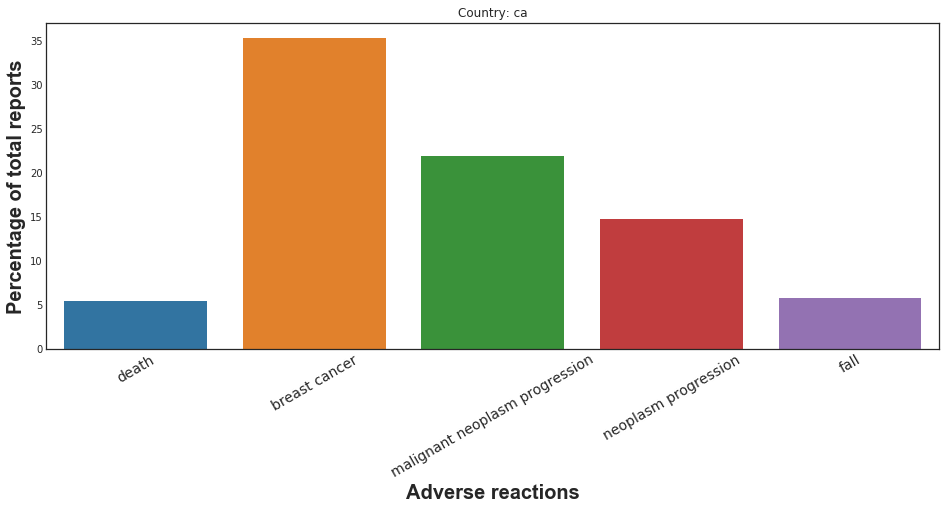

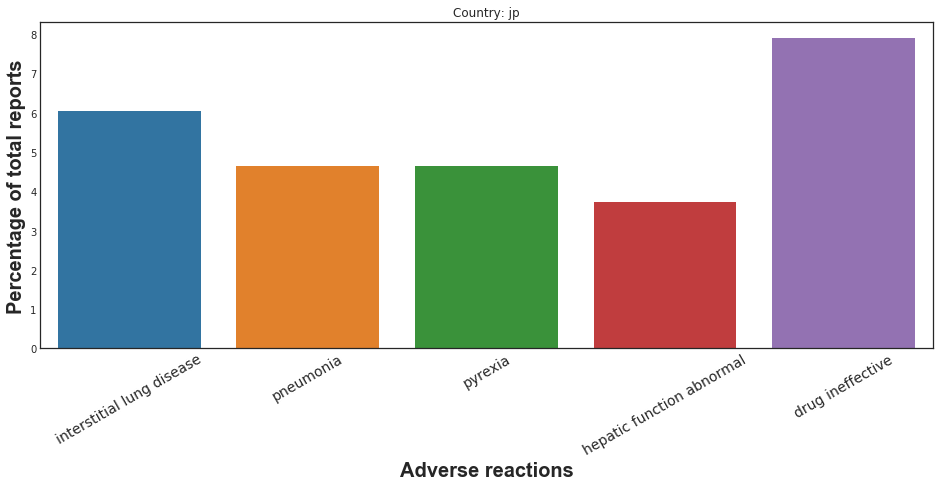

In [276]:
# For each country plot highly reported Adverse drug reactions

with plt.style.context('seaborn-white'):
    #fig,ax = plt.subplots(5,figsize=(12,20))
    for i,country in enumerate(countries):
        data_df=df3[df3.country==country]
        fig,ax = plt.subplots(1,figsize=(16,6))
        sns.barplot(x="reactions", y="percentage_of_report", data=data_df)
        ax.set_xlabel('Adverse reactions', fontname = 'Arial', fontdict=dict(weight='bold'), fontsize = 20)
        ax.set_ylabel('Percentage of total reports', fontname = 'Arial', fontdict=dict(weight='bold'), fontsize = 20)
        ax.tick_params(axis='x', rotation = 30,labelsize = 14)
        ax.set_title("Country: {}".format(country))
        
                    
        #ax[i].plot(sns.barplot(x="reactions", y="percentage_of_report", data=df3[df3.country==country]))
        #ax[i].set_title("Country: {}".format(country))

In [198]:
# tokenize and then for each country create a dictionary of ADE
reaction_by_country = defaultdict(list)
for i, row in df2.iterrows():
    reaction_by_country[row['country']].extend(row['reactions'])
reaction_by_country['ca']

['subdural haematoma',
 'asthenia',
 'palpitations',
 'thirst',
 'gait disturbance',
 'death',
 'influenza',
 'weight decreased',
 'nasopharyngitis',
 'fall',
 'confusional state',
 'bone density decreased',
 'convulsion',
 'pulmonary oedema',
 'death',
 'neoplasm malignant',
 'pain in extremity',
 'anaemia',
 'death',
 'histiocytosis haematophagic',
 'suicidal ideation',
 'depressed mood',
 'nightmare',
 'alopecia',
 'rash papular',
 'contusion',
 'platelet count decreased',
 'cerebrovascular accident',
 'dysuria',
 'pain',
 'catheter placement',
 'bladder pain',
 'genital pain',
 'nocturia',
 'pneumonia',
 'cough',
 'wheezing',
 'bronchitis',
 'nasopharyngitis',
 'asthma',
 'pneumonia',
 'cough',
 'drug hypersensitivity',
 'increased upper airway secretion',
 'rash',
 'pneumonia viral',
 'cough',
 'drug hypersensitivity',
 'increased upper airway secretion',
 'rash',
 'diplopia',
 'eye pain',
 'lacrimation increased',
 'ocular hyperaemia',
 'photophobia',
 'scab',
 'vision blurred',


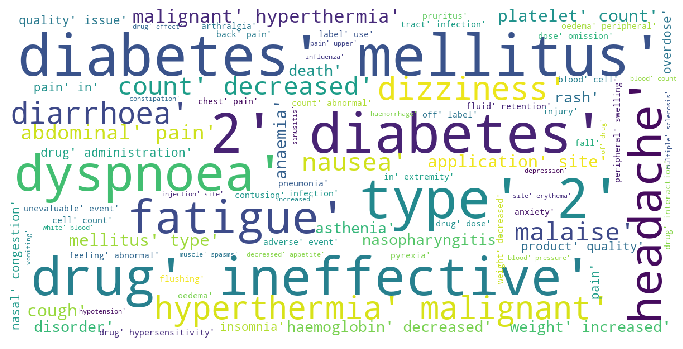

In [287]:
# Show visual word cloud with high frequence ADE terms for top cuntries 
def generate_cloud(reaction_by_country,country):
    reactions = reaction_by_country[country]
    reactions = [x.split() for x in reactions]
    reactions_list = []
    for word in reactions:
        reactions_list.extend(word)

    show_wordcloud(reactions_list)

generate_cloud(reaction_by_country,'us')




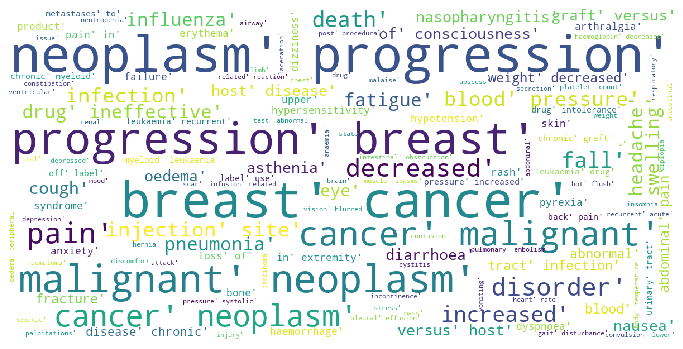

In [288]:
# Show visual word cloud with high frequence ADE terms for top cuntries 


generate_cloud(reaction_by_country,'ca')

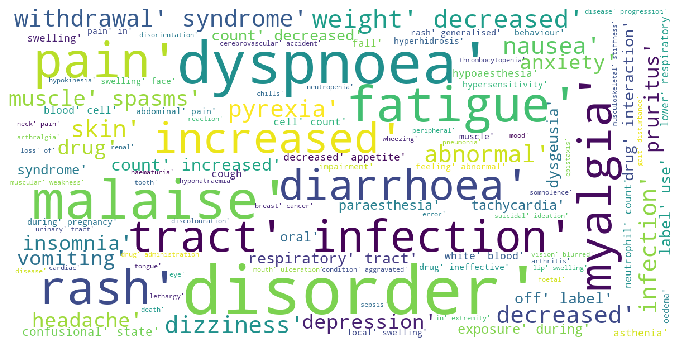

In [289]:
# Show visual word cloud with high frequence ADE terms for top cuntries 


generate_cloud(reaction_by_country,'gb')

In [315]:
# find disease areas where ADEs are reported
df2 = df[['drugindication', 'reactions']]
df2.head()

,drugindication,reactions
0,[drug abuse],"[drug administration error, overdose]"
1,[osteoporosis],"[vomiting, diarrhoea, arthralgia, headache]"
2,[product used for unknown indication],"[dyspepsia, renal impairment]"
3,[None],[drug ineffective]
4,"[None, None, None, None, None, None, None, Non...",[drug hypersensitivity]


In [312]:
# convert a list of reaction to multiple rows in this dataframe with indvidual row for each element

df3 = pd.DataFrame(df2.reactions.tolist(), index=df2.index).stack()
df3 = df3.reset_index()[['level_0',0]]
df3.columns = ['id', 'reactions']
df3.head()

,id,reactions
0,0,drug administration error
1,0,overdose
2,1,vomiting
3,1,diarrhoea
4,1,arthralgia


In [318]:
# convert a list of indications to multiple rows in this dataframe with indvidual row for each element


df2 = pd.DataFrame(df2.drugindication.tolist(), index=df2.index).stack()
df2 = df2.reset_index()[['level_0',0]]
df2.columns = ['id', 'drugindication']
df2.head()

,id,drugindication
0,0,drug abuse
1,1,osteoporosis
2,2,product used for unknown indication
3,6,product used for unknown indication
4,7,pulmonary hypertension


In [319]:
df2 = pd.merge(df2,df3,how= 'left', on = 'id')
df2.head()

,id,drugindication,reactions
0,0,drug abuse,drug administration error
1,0,drug abuse,overdose
2,1,osteoporosis,vomiting
3,1,osteoporosis,diarrhoea
4,1,osteoporosis,arthralgia


In [323]:
# Disease areas with high ADR
df3 = df2.groupby(['drugindication'],as_index = False)[['id']].count()
df3.sort_values(by=['id'],ascending = False).head(10)

,drugindication,id
723,product used for unknown indication,6154
572,myelofibrosis,2719
559,multiple sclerosis,2309
742,pulmonary arterial hypertension,1207
785,rheumatoid arthritis,947
682,peritoneal dialysis,933
747,pulmonary hypertension,851
140,breast cancer,671
421,hypertension,658
247,depression,633


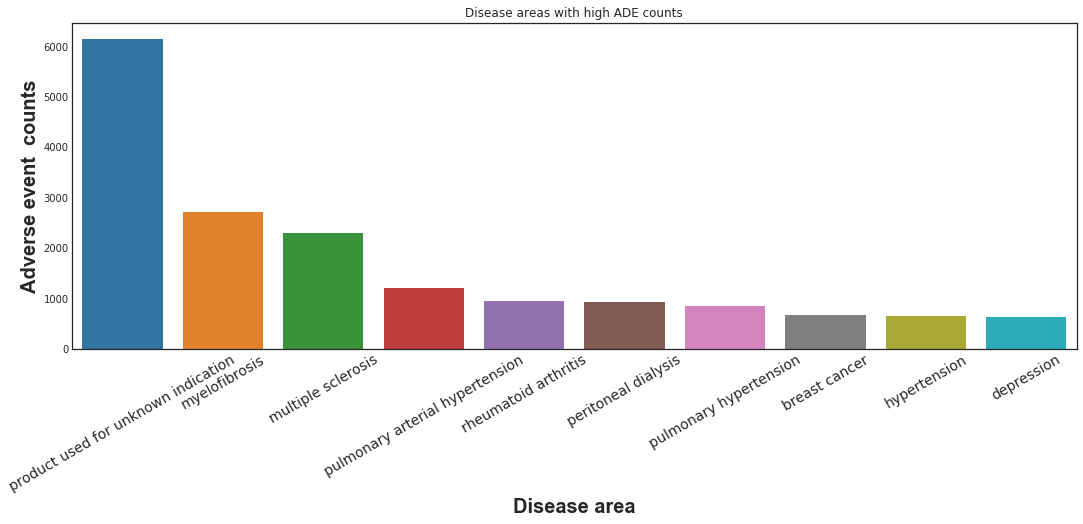

In [328]:
#plot top disease areas with high ADE counts

with plt.style.context('seaborn-white'):
        data_df = df3.sort_values(by=['id'],ascending = False).head(10)
        fig,ax = plt.subplots(1,figsize=(18,6))
        sns.barplot(x="drugindication", y="id", data=data_df)
        ax.set_xlabel('Disease area', fontname = 'Arial', fontdict=dict(weight='bold'), fontsize = 20)
        ax.set_ylabel('Adverse event  counts', fontname = 'Arial', fontdict=dict(weight='bold'), fontsize = 20)
        ax.tick_params(axis='x', rotation = 30,labelsize = 14)
        ax.set_title('Disease areas with high ADE counts')
        
                    
        #ax[i].plot(sns.barplot(x="reactions", y="percentage_of_report", data=df3[df3.country==country]))
        #ax[i].set_title("Country: {}".format(country))

In [335]:
# Create disease-ADE combination
df4 = df2.groupby(['drugindication','reactions'],as_index = False)[['id']].count()
df4 = df4.sort_values(by=['id'],ascending = False)
df4['Disease-ADE'] = df4.drugindication+' - '+df4.reactions
df4 = df4[df4.drugindication != 'product used for unknown indication']
df4.head()

,drugindication,reactions,id,Disease-ADE
7471,low density lipoprotein increased,type 2 diabetes mellitus,444,low density lipoprotein increased - type 2 dia...
2667,cardiovascular event prophylaxis,type 2 diabetes mellitus,435,cardiovascular event prophylaxis - type 2 diab...
468,anaesthesia,hyperthermia malignant,403,anaesthesia - hyperthermia malignant
1772,blood cholesterol increased,type 2 diabetes mellitus,165,blood cholesterol increased - type 2 diabetes ...
8942,myelofibrosis,fatigue,117,myelofibrosis - fatigue


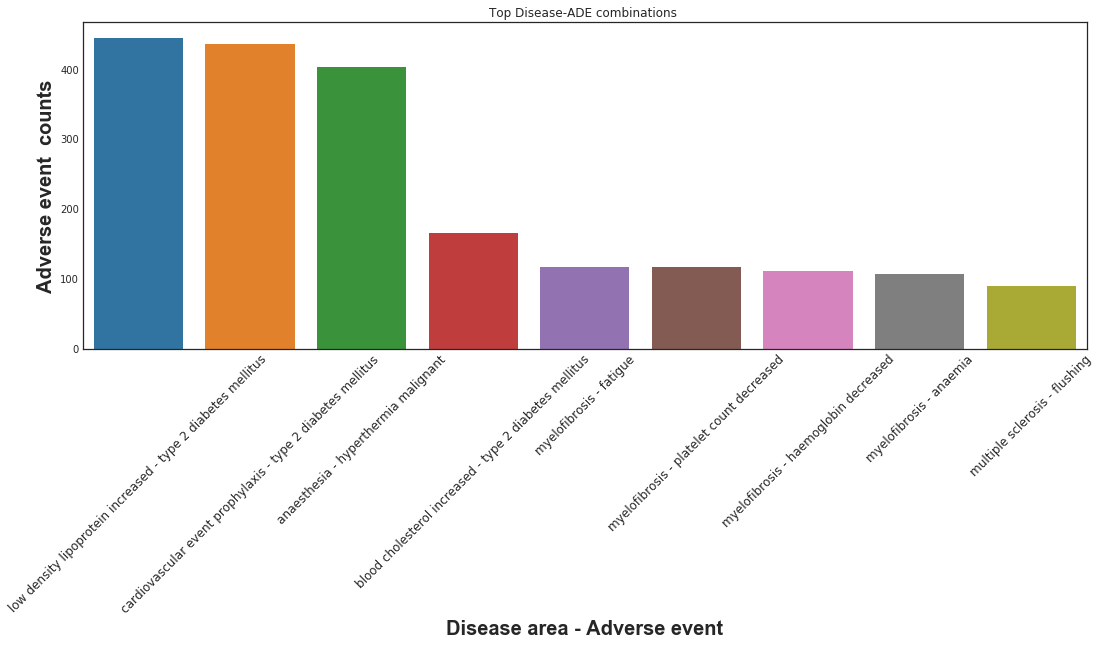

In [338]:
#plot disease-ADE combination
with plt.style.context('seaborn-white'):
        data_df = df4.head(9)
        fig,ax = plt.subplots(1,figsize=(18,6))
        sns.barplot(x="Disease-ADE", y="id", data=data_df)
        ax.set_xlabel('Disease area - Adverse event', fontname = 'Arial', fontdict=dict(weight='bold'), fontsize = 20)
        ax.set_ylabel('Adverse event  counts', fontname = 'Arial', fontdict=dict(weight='bold'), fontsize = 20)
        ax.tick_params(axis='x', rotation = 45,labelsize = 12)
        ax.set_title('Top Disease-ADE combinations ')

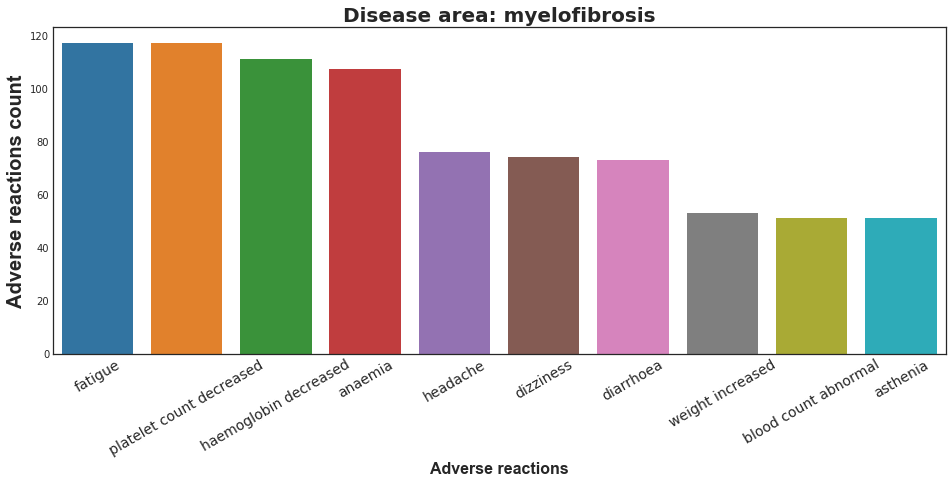

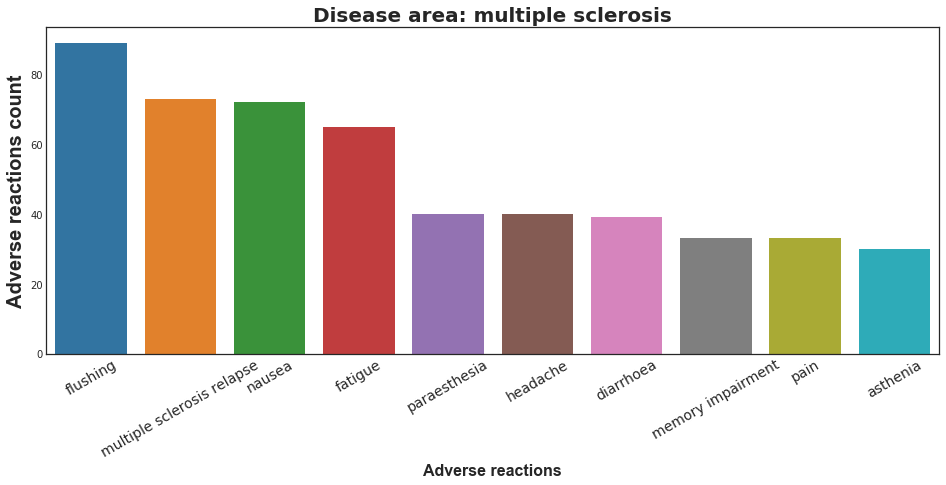

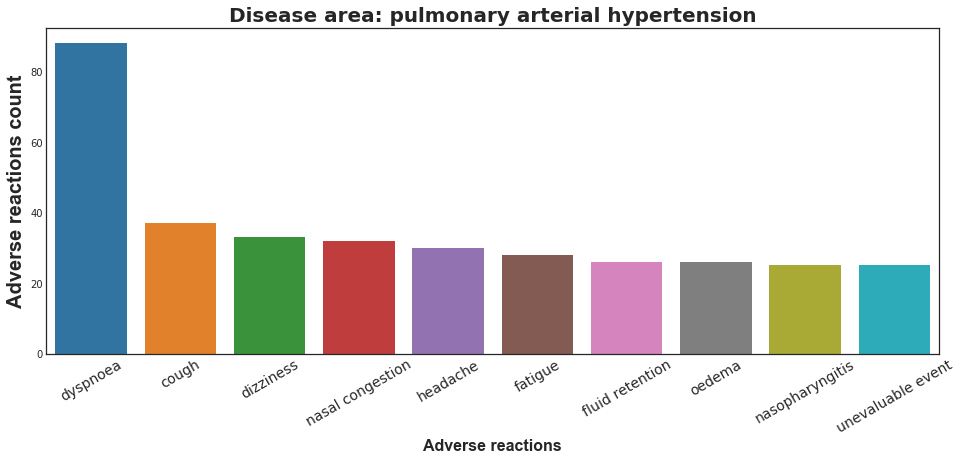

In [345]:
# plot for top disease areas highest ADE report types
diseases = ['myelofibrosis', 'multiple sclerosis', 'pulmonary arterial hypertension']
with plt.style.context('seaborn-white'):
    #fig,ax = plt.subplots(5,figsize=(12,20))
    for i,disease in enumerate(diseases):
        data_df=df4[df4.drugindication==disease].head(10)
        fig,ax = plt.subplots(1,figsize=(16,6))
        sns.barplot(x="reactions", y="id", data=data_df)
        ax.set_xlabel('Adverse reactions', fontname = 'Arial', fontdict=dict(weight='bold'), fontsize = 16)
        ax.set_ylabel('Adverse reactions count', fontname = 'Arial', fontdict=dict(weight='bold'), fontsize = 20)
        ax.tick_params(axis='x', rotation = 30,labelsize = 14)
        ax.set_title("Disease area: {}".format(disease),fontdict=dict(weight='bold'), fontsize = 20)
        
                    
        #ax[i].plot(sns.barplot(x="reactions", y="percentage_of_report", data=df3[df3.country==country]))
        #ax[i].set_title("Country: {}".format(country))

In [354]:
# find which drugs are taken together
df2 = df[['suspect_drug', 'concomitant_drug']]


In [355]:
# convert a list of suspect_drug to multiple rows in this dataframe with indvidual row for each element


df3 = pd.DataFrame(df2.suspect_drug.tolist(), index=df2.index).stack()
df3 = df3.reset_index()[['level_0',0]]
df3.columns = ['id', 'suspect_drug']
df3.head()

,id,suspect_drug
0,0,duragesic-100
1,1,boniva
2,2,ibuprofen
3,3,lyrica
4,4,doxycycline hyclate


In [356]:
df2 = df2.reset_index()
df2 = df2.rename(columns={'index':'id','suspect_drug':'drug'})
df2.head()

,id,drug,concomitant_drug
0,0,[duragesic-100],[]
1,1,[boniva],[]
2,2,[ibuprofen],[]
3,3,[lyrica],[]
4,4,"[doxycycline hyclate, tramadol hydrochloride, ...",[]


In [357]:
df3 = pd.merge(df3,df2,how= 'left', on = 'id')
df3.head(10)

,id,suspect_drug,drug,concomitant_drug
0,0,duragesic-100,[duragesic-100],[]
1,1,boniva,[boniva],[]
2,2,ibuprofen,[ibuprofen],[]
3,3,lyrica,[lyrica],[]
4,4,doxycycline hyclate,"[doxycycline hyclate, tramadol hydrochloride, ...",[]
5,4,tramadol hydrochloride,"[doxycycline hyclate, tramadol hydrochloride, ...",[]
6,4,oxycontin,"[doxycycline hyclate, tramadol hydrochloride, ...",[]
7,4,talwin,"[doxycycline hyclate, tramadol hydrochloride, ...",[]
8,4,codeine,"[doxycycline hyclate, tramadol hydrochloride, ...",[]
9,4,iodine,"[doxycycline hyclate, tramadol hydrochloride, ...",[]


In [366]:
# create a drug dictionary for each primary drug - values are the drugs which were togetehr with primary drug
drug_dict = defaultdict(list)
for i, row in df3.iterrows():
    drug_dict[row['suspect_drug']].extend(row['drug'])
    drug_dict[row['suspect_drug']].extend(row['concomitant_drug'])
drug_dict['iodine']

['doxycycline hyclate',
 'tramadol hydrochloride',
 'oxycontin',
 'talwin',
 'codeine',
 'iodine',
 'aspirin',
 'lortab',
 'fiorinal']

In [371]:
# generate count to find how many times drug1 and drug2 were taken together
drugs = {}
for k,v in drug_dict.items():
    drugs[k] = Counter(v)
drugs['iodine']

Counter({'doxycycline hyclate': 1,
         'tramadol hydrochloride': 1,
         'oxycontin': 1,
         'talwin': 1,
         'codeine': 1,
         'iodine': 1,
         'aspirin': 1,
         'lortab': 1,
         'fiorinal': 1})

In [372]:
# convert the dict to a df with drug1 and drug2 and the counts
drug_df = pd.DataFrame()
for k,v in drugs.items():
    df3 = pd.DataFrame.from_dict(v, orient='index').reset_index()
    df3.columns = ['drug2','count']
    df3['drug1'] = k
    drug_df = drug_df.append(df3)


In [373]:
drug_df.head(10)

,drug2,count,drug1
0,duragesic-100,1,duragesic-100
0,boniva,3,boniva
1,fosamax,2,boniva
2,alendronate sodium.,1,boniva
0,ibuprofen,28,ibuprofen
1,lipitor,1,ibuprofen
2,paracetamol,5,ibuprofen
3,bupropion,1,ibuprofen
4,citalopram,2,ibuprofen
5,diclofenac,1,ibuprofen


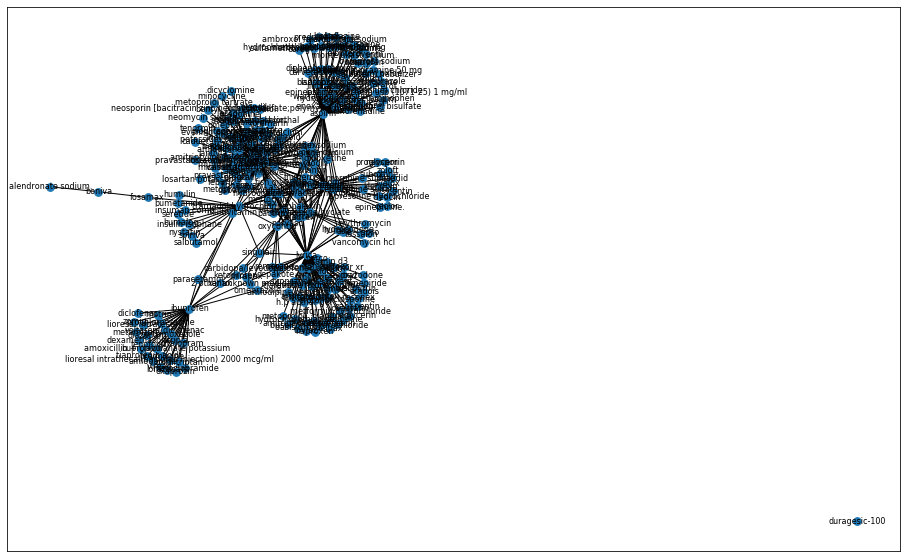

In [402]:
# create a network visualization of drugs taken together
G_weighted = nx.Graph()

for i, row in drug_df.iterrows():
    G_weighted.add_edge(row['drug1'],row['drug2'], weight=row['count'])
    if i >100:
        break
# with 100 rows only
plt.figure(1,figsize=(16,10)) 
nx.draw_networkx(G_weighted,node_size=60,font_size=8)
plt.show()

In [403]:
# create the full graph
G_weighted = nx.Graph()

for i, row in drug_df.iterrows():
    G_weighted.add_edge(row['drug1'],row['drug2'], weight=row['count'])
   

In [410]:
# find graph meta info
print(nx.info(G_weighted))

Name: 
Type: Graph
Number of nodes: 5254
Number of edges: 21550
Average degree:   8.2033


In [415]:
# the nodes which themseleves are highly connected
digCent = nx.degree_centrality(G_weighted)
sorted(digCent, key=digCent.get, reverse=True)[:5]



['jakafi', 'tecfidera', 'revlimid', 'humira', 'lipitor']

In [418]:
# the nodes that are connected to highly connected nodes
eigCent = nx.eigenvector_centrality(G_weighted)
sorted(eigCent, key=eigCent.get, reverse=True)[:5]



['jakafi', 'revlimid', 'omeprazole', 'lipitor', 'aspirin']

In [411]:
# the nodes which are stops in between highly connected nodes (highways stop)
betCent = nx.betweenness_centrality(G_weighted, normalized=True, endpoints=True)
sorted(betCent, key=betCent.get, reverse=True)[:5]


['jakafi', 'tecfidera', 'humira', 'revlimid', 'prednisone']